Install Dependencies

In [1]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 12.1MB/s 
     |████████████████████████████████| 952kB 23.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=8baa1b243035270125ce8cf98b4b8b28027f60330c6b250f797d6162d3143a93
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 27853, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 27853 (delta 300), reused 360 (delta 276), pack-reused 27452
Receiving objects: 100% (27853/27853), 36.04 MiB | 22.34 MiB/s, done.
Resolving deltas: 100% (20912/20912), done.
fatal: not a git repository (or any of the parent directories): .git


Mount Google Drive

In [3]:
# Connect to drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Copy data from google drive to colab session

In [4]:
!cp -r /content/gdrive/MyDrive/SoftComputingData/model_state_dict_resnet.pt /content
!cp -r /content/gdrive/MyDrive/SoftComputingData/model_state_dict_mobilenet.pt /content

In [5]:
#!unzip '/content/gdrive/MyDrive/SoftComputingData/Medical Mask.zip'
!unzip '/content/gdrive/MyDrive/SoftComputingData/processed_data.zip'
!unzip '/content/gdrive/MyDrive/SoftComputingData/predictions image.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Processed_data/images/1097.jpg  
  inflating: Processed_data/images/1098.jpg  
  inflating: Processed_data/images/1099.jpg  
  inflating: Processed_data/images/1101.jpg  
  inflating: Processed_data/images/1102.jpg  
  inflating: Processed_data/images/1103.png  
  inflating: Processed_data/images/1104.jpg  
  inflating: Processed_data/images/1105.jpg  
  inflating: Processed_data/images/1106.jpg  
  inflating: Processed_data/images/1107.jpg  
  inflating: Processed_data/images/1108.jpg  
  inflating: Processed_data/images/1109.jpg  
  inflating: Processed_data/images/1110.jpg  
  inflating: Processed_data/images/1111.jpg  
  inflating: Processed_data/images/1112.jpg  
  inflating: Processed_data/images/1113.jpg  
  inflating: Processed_data/images/1114.png  
  inflating: Processed_data/images/1115.jpg  
  inflating: Processed_data/images/1116.jpg  
  inflating: Processed_data/images/1117.jpg  
  inflating: Processed_data/i

Import Dependencies

In [6]:
import math
import pandas as pd
import cv2
import numpy as np
import json

from PIL import Image, ImageDraw, ImageFont

#import tensorflow as tf
#from tensorflow.keras.utils import Sequence # for data loading

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [7]:
class_mapping = {'face_no_mask' : 0,
                 'face_with_mask_incorrect' : 1,
                 'face_with_mask' : 2,
                 'mask_colorful' : 3,
                 'mask_surgical' : 4,
                 'face_other_covering' : 5,
                 'balaclava_ski_mask' : 6,
                 'gas_mask' : 7,
                 'face_shield' : 8,
                 }

Dataset Class

In [8]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
        
class FaceMaskDataset(Dataset):
    def __init__(self, image_list, root_dir, transforms=None):
        self.image_list = image_list
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        with open(self.root_dir + '/annotations/' + self.image_list.iloc[idx, 0]) as f:
            json_data = json.load(f)
        
        img_name = self.root_dir + '/images/' + json_data['FileName']
        input_image = cv2.imread(img_name)
        image_size = (input_image.shape[0], input_image.shape[1])
        input_image = input_image/255
        #input_image = transforms.ToTensor()(input_image)

        output_target = {}
        output_target['boxes'] = []
        output_target['labels'] = []
        output_target['image_id'] = int(json_data['FileName'].split('.')[0])
        output_target['area'] = []
        output_target['iscrowd'] = []

        # get bounding box from json
        for anno in json_data['Annotations']:
            if anno['BoundingBox'][0] == anno['BoundingBox'][2] or anno['BoundingBox'][1] == anno['BoundingBox'][2]:
                continue
            output_target['boxes'].append(anno['BoundingBox'])
            output_target['labels'].append(class_mapping[anno['classname']])
            area = (anno['BoundingBox'][2]-anno['BoundingBox'][0]) * (anno['BoundingBox'][3]-anno['BoundingBox'][0])
            output_target['area'].append(area)
            output_target['iscrowd'].append(0)
        
        # convert to tensor
        output_target['boxes'] = torch.as_tensor(output_target['boxes'], dtype=torch.float32)
        output_target['labels'] = torch.as_tensor(output_target['labels'], dtype=torch.int64)
        output_target['image_id'] = torch.as_tensor(output_target['image_id'], dtype=torch.int64)
        output_target['area'] = torch.as_tensor(output_target['area'], dtype=torch.float32)
        output_target['iscrowd'] = torch.as_tensor(output_target['iscrowd'], dtype=torch.uint8)

        # clip the bounding box to image size
        output_target['boxes'] = torchvision.ops.clip_boxes_to_image(output_target['boxes'], image_size)

        # data augmentation
        if self.transforms:
            sample = self.transforms(image = input_image,
                                     bboxes = output_target['boxes'],
                                     labels = output_target['labels'])
            
            input_image = torch.as_tensor(sample['image'], dtype=torch.float32)
            output_target['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)

        return input_image, output_target

Load dataset and split dataset into test train set

In [9]:
df = pd.read_csv('json_data_processed.csv')

In [10]:
# Split the dataset into training set and validation set
X_train, X_val = train_test_split(df, test_size=0.2, random_state=0)

Intialize Dataset object and DataLoader

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

# train_data = FaceMaskDataset(X_train, 'Processed_data/')
# validation_data = FaceMaskDataset(X_val, 'Processed_data/')

train_data = FaceMaskDataset(X_train, 'Processed_data/', transforms=get_transform(train=True))
validation_data = FaceMaskDataset(X_val, 'Processed_data/', transforms=get_transform(train=False))

batch_size = 4 # 16 for mobilenet

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Model

In [35]:
num_classes = 9

#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

# # to train on gpu if selected.
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# # move model to the right device
# model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [36]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to numpy image
def torch_to_numpy(img):
    return img.permute(1, 2, 0).numpy() *255
    

Training

In [13]:
def train(model, optimizer, lr_Scheduler, total_epoch, train_loader, val_loader):
    for epoch in range(total_epoch):
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, val_loader, device=device)


MobileNetv3-Large-FPN - Augmentation

In [15]:
num_epoch = 5

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
train(model, optimizer, lr_scheduler, num_epoch, train_dataloader, validation_dataloader)

torch.save(model.state_dict(), 'model_state_dict_mobilenet.pt')

Epoch: [0]  [  0/865]  eta: 0:11:51  lr: 0.000022  loss: 2.4890 (2.4890)  loss_classifier: 2.0263 (2.0263)  loss_box_reg: 0.2633 (0.2633)  loss_objectness: 0.1860 (0.1860)  loss_rpn_box_reg: 0.0135 (0.0135)  time: 0.8223  data: 0.1720  max mem: 1415
Epoch: [0]  [ 10/865]  eta: 0:07:18  lr: 0.000137  loss: 2.4219 (2.4057)  loss_classifier: 2.0097 (1.9523)  loss_box_reg: 0.2025 (0.2102)  loss_objectness: 0.1860 (0.2011)  loss_rpn_box_reg: 0.0426 (0.0421)  time: 0.5128  data: 0.2202  max mem: 2369
Epoch: [0]  [ 20/865]  eta: 0:05:55  lr: 0.000253  loss: 2.1413 (2.0182)  loss_classifier: 1.5207 (1.5275)  loss_box_reg: 0.2259 (0.2667)  loss_objectness: 0.1653 (0.1813)  loss_rpn_box_reg: 0.0379 (0.0427)  time: 0.4006  data: 0.1563  max mem: 2369
Epoch: [0]  [ 30/865]  eta: 0:05:54  lr: 0.000368  loss: 1.2379 (1.7113)  loss_classifier: 0.7025 (1.2178)  loss_box_reg: 0.2910 (0.2920)  loss_objectness: 0.1226 (0.1624)  loss_rpn_box_reg: 0.0253 (0.0390)  time: 0.3768  data: 0.1365  max mem: 2369


Resnet-50-FPN - Augmentation

In [ ]:
num_epoch = 5

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
train(model, optimizer, lr_scheduler, num_epoch, train_dataloader, validation_dataloader)

Epoch: [0]  [  0/865]  eta: 0:25:14  lr: 0.000022  loss: 2.7131 (2.7131)  loss_classifier: 2.5480 (2.5480)  loss_box_reg: 0.1195 (0.1195)  loss_objectness: 0.0359 (0.0359)  loss_rpn_box_reg: 0.0097 (0.0097)  time: 1.7508  data: 0.2014  max mem: 5062
Epoch: [0]  [ 10/865]  eta: 0:22:59  lr: 0.000137  loss: 2.4865 (2.4978)  loss_classifier: 2.3213 (2.2390)  loss_box_reg: 0.1829 (0.1806)  loss_objectness: 0.0653 (0.0654)  loss_rpn_box_reg: 0.0124 (0.0128)  time: 1.6136  data: 0.2513  max mem: 7789
Epoch: [0]  [ 20/865]  eta: 0:22:19  lr: 0.000253  loss: 1.8290 (1.8382)  loss_classifier: 1.4530 (1.5548)  loss_box_reg: 0.1888 (0.1979)  loss_objectness: 0.0663 (0.0725)  loss_rpn_box_reg: 0.0124 (0.0130)  time: 1.5772  data: 0.2476  max mem: 8138
Epoch: [0]  [ 30/865]  eta: 0:20:56  lr: 0.000368  loss: 0.6607 (1.4088)  loss_classifier: 0.4167 (1.1492)  loss_box_reg: 0.1888 (0.1922)  loss_objectness: 0.0258 (0.0553)  loss_rpn_box_reg: 0.0107 (0.0121)  time: 1.4452  data: 0.1814  max mem: 8138


Save model

In [ ]:
torch.save(model.state_dict(), 'model_state_dict_resnet.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load Model

In [ ]:
# upload weight
from google.colab import files
uploaded = files.upload() 

Saving model_state_dict.pt to model_state_dict.pt


In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

PATH = 'model_state_dict_resnet.pt'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [38]:
def predict(img):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        final_prediction = apply_nms(prediction, iou_thresh=0.5)
    
    return final_prediction

def get_class(index):
    for key, value in class_mapping.items():
         if index[0] == value:
             return key
    return 'Class No Exist'

def get_class2(index):
    for key, value in class_mapping.items():
         if index == value:
             return key
    return 'Class No Exist'

def torch_to_PIL(image):
    return transforms.ToPILImage()(image)

def torch_to_numpy(image):
    return image.permute(1,2,0).numpy() *255

Visualization

In [ ]:
font = ImageFont.truetype(r'/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', 20) 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
for img, target in train_dataloader:
    for idx in range(len(img)):
        image = img[idx]
        label_target = target[idx]
        image_plot = torch_to_PIL(image)
        b, g, r = image_plot.split()
        image_plot = Image.merge("RGB", (r, g, b))
        predictions = predict(image)
        print('Index' , idx)
        print('Predictions:')
        print(predictions)
        print('Labels:')
        print(label_target)

        draw = ImageDraw.Draw(image_plot)  

        # # groud truth value
        # ground_bboxs = label_target['boxes'].detach().cpu().numpy()
        # ground_labels = label_target['labels'].detach().cpu().numpy()
        # # draw bbox and label for ground truth
        # for i in range(len(ground_bboxs)):
        #     x1 = int(ground_bboxs[i,0])
        #     y1 = int(ground_bboxs[i,1])
        #     x2 = int(ground_bboxs[i,2])
        #     y2 = int(ground_bboxs[i,3])
        #     image_plot = cv2.rectangle(image_plot, (x1, y1), (x2, y2), (255,0,0), 1)
        #     image_plot = cv2.putText(image_plot, get_class(ground_labels[i]), (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

        # get prediction bbox and labels
        bboxs = predictions['boxes'].detach().cpu().numpy()
        labels = predictions['labels'].detach().cpu().numpy()
        print(labels)

        # draw bbox and label for predictions
        for i in range(len(bboxs)):
            x1 = int(bboxs[i,0])
            y1 = int(bboxs[i,1])
            x2 = int(bboxs[i,2])
            y2 = int(bboxs[i,3])
            draw.rectangle([x1,y1,x2,y2], outline ="red")
            draw.text((x1, y1-10), get_class([labels[i]]), font = font, align ="left") 
            #image_plot = cv2.rectangle(image_plot, (x1, y1), (x2, y2), (36,255,12), 1)
            #image_plot = cv2.putText(image_plot, get_class(labels[i]), (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
        
        
        im_array = np.asarray(image_plot)
        plt.imshow(im_array)
        plt.show()
        #cv2_imshow(image_plot.get())


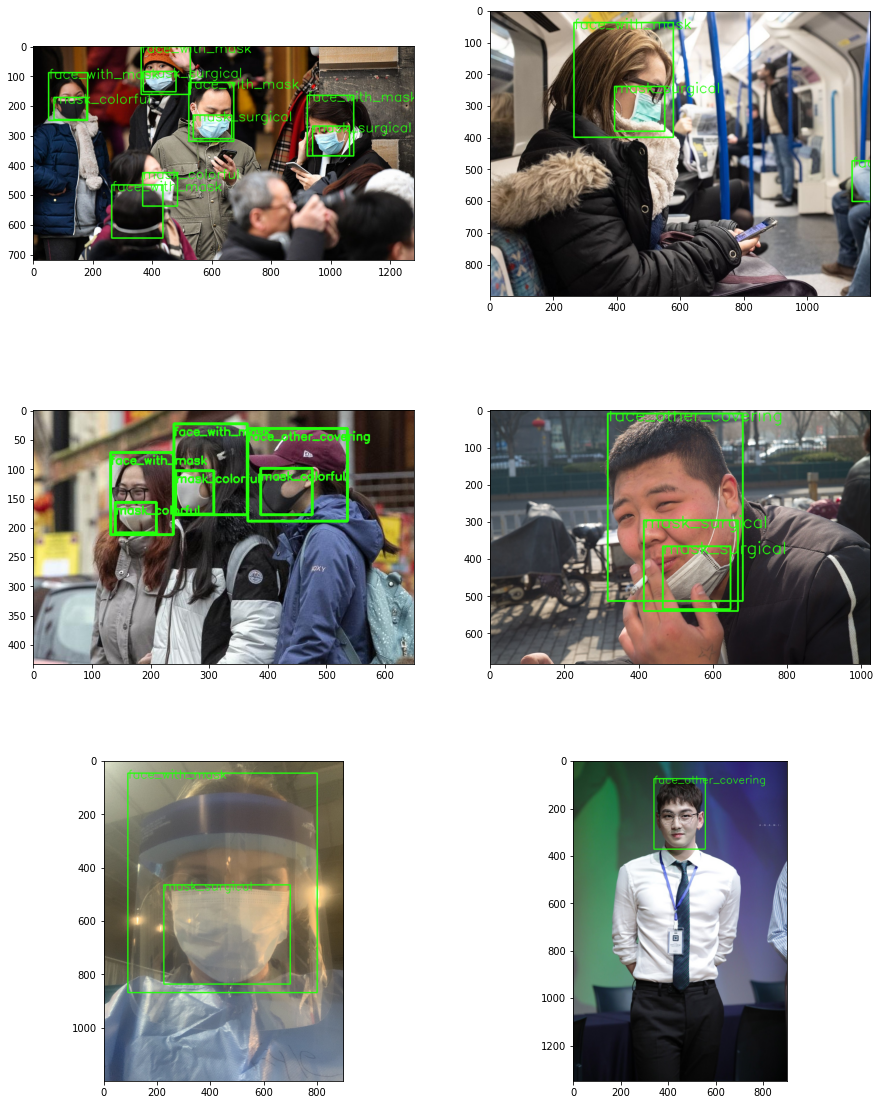

In [61]:
test_images = ['0025.jpg', # mulitple ppl mask
               '0059.jpg', # mask side face
               '0279.jpg', # mutiple ppl, colour, surgical, incorrect
               '0618.jpg', # incorrect
               '1005.jpg', # mask, face shield
               '1141.jpg'  # no mask
               ]

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15,20))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for idx in range(len(test_images)):
    img_name = 'Processed_data/images/' + test_images[idx]
    plot_image = cv2.imread(img_name)
    plot_image = cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB)
    input_image = plot_image/255
    input_image = transforms.ToTensor()(input_image)
    input_image = torch.as_tensor(input_image, dtype=torch.float32)

    if plot_image.shape[1] > 1000 or plot_image.shape[0] > 1000:
        fontScale = 1.5
    else:
        fontScale = min(plot_image.shape[1],plot_image.shape[0])/max(plot_image.shape[1],plot_image.shape[0])
    
    predictions = predict(input_image)

    # get prediction bbox and labels
    bboxs = predictions['boxes'].detach().cpu().numpy()
    labels = predictions['labels'].detach().cpu().numpy()

    # draw bbox and label for predictions
    for i in range(len(bboxs)):
        x1 = int(bboxs[i,0])
        y1 = int(bboxs[i,1])
        x2 = int(bboxs[i,2])
        y2 = int(bboxs[i,3])
        # draw.rectangle([x1,y1,x2,y2], outline ="red")
        # draw.text((x1, y1-10), get_class([labels[i]]), font = font, align ="left") 
        plot_image = cv2.rectangle(plot_image, (x1, y1), (x2, y2), (36,255,12), 3)
        plot_image = cv2.putText(plot_image, get_class2(labels[i]), (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (36,255,12), 2)

    fig.add_subplot(3,2,idx+1)
    im_array = np.asarray(plot_image)
    plt.imshow(im_array)

plt.show()
#fig.savefig('resnet_predictions.png')

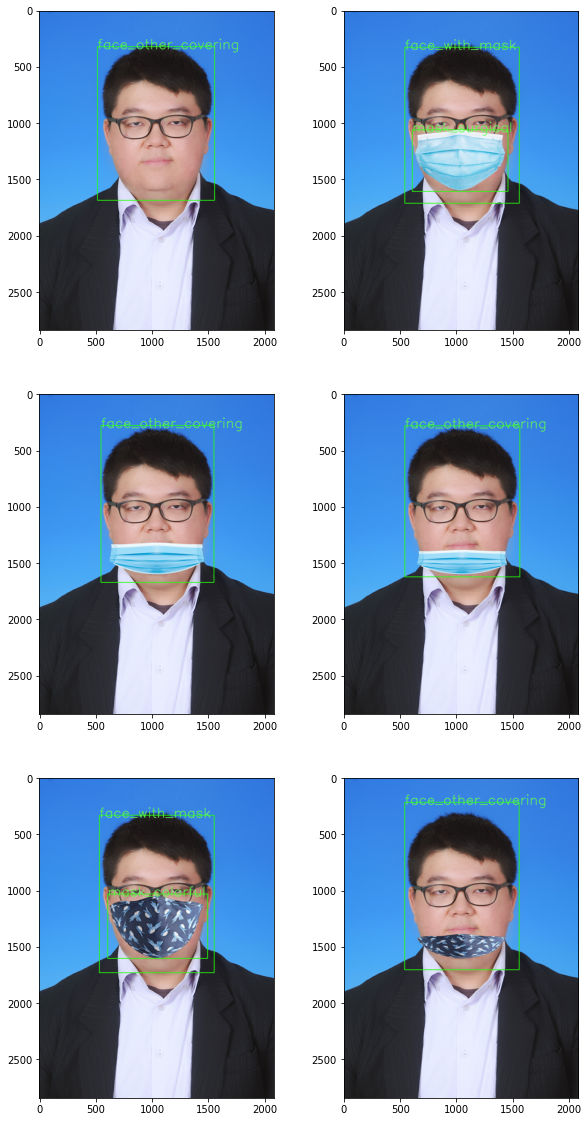

In [39]:
test_images = ['nomask.jpg', 
               'correct_surgical.png', 
               'incorrect_nose_not_covered_surgical.png',
               'incorrect_below_chin_surgical.png', 
               'correct_cloth.png', 
               'incorrect_below_chin_cloth.png'
               ]

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,20))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for idx in range(len(test_images)):
    img_name = test_images[idx]
    plot_image = cv2.imread(img_name)
    plot_image = cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB)
    input_image = plot_image/255
    input_image = transforms.ToTensor()(input_image)
    input_image = torch.as_tensor(input_image, dtype=torch.float32)

    
    predictions = predict(input_image)

    # get prediction bbox and labels
    bboxs = predictions['boxes'].detach().cpu().numpy()
    labels = predictions['labels'].detach().cpu().numpy()
    
    color = (36,255,12)

    # draw bbox and label for predictions
    for i in range(len(bboxs)):
        x1 = int(bboxs[i,0])
        y1 = int(bboxs[i,1])
        x2 = int(bboxs[i,2])
        y2 = int(bboxs[i,3])
        # draw.rectangle([x1,y1,x2,y2], outline ="red")
        # draw.text((x1, y1-10), get_class([labels[i]]), font = font, align ="left") 
        plot_image = cv2.rectangle(plot_image, (x1, y1), (x2, y2), (36,255,12), 5)
        plot_image = cv2.putText(plot_image, get_class2(labels[i]), (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 4, (255,255,255), 5)
        plot_image = cv2.putText(plot_image, get_class2(labels[i]), (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 4, (36,255,12), 4)

    fig.add_subplot(3,2,idx+1)
    im_array = np.asarray(plot_image)
    plt.imshow(im_array)

plt.show()
fig.savefig('resnet_predictions.png')

FPS calculation

In [86]:
#fps calculation

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

import time
start_time = time.time()


for img, target in validation_dataloader:
    for idx in range(len(img)):
        image = img[idx]
        label_target = target[idx]
        predictions = predict(image)

end_time = time.time()

difference = end_time - start_time

print('Time taken: ', difference)
print('FPS: ', len(validation_data)/difference)
          

Time taken:  45.27587699890137
FPS:  19.105096517975554


Number of Parameters Counting

In [84]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

18907208